In [1]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
import albumentations as A
from PIL import Image
from albumentations.pytorch import ToTensor
from utility_fun import *

In [3]:
import matplotlib.pyplot as plt

In [4]:
from read_inputs import read_transform_inputs
trainset, trainloader, testset, testloader, classes = read_transform_inputs()

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
plane truck  frog   cat


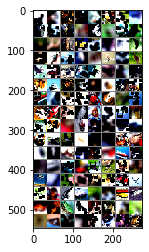

In [5]:

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
from model import ResNet
from model import BasicBlock
from model import Bottleneck

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [8]:
model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
show_model_summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [9]:
### Optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

  pip install torch-lr-finder -v --global-option="amp"
 73%|███████▎  | 287/391 [15:45<05:31,  3.19s/it]Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


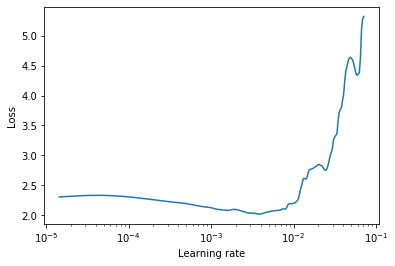

In [10]:
##LR Finder
from lr_finder import LRFinder
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, val_loader=testloader, start_lr=1e-5, end_lr=2,num_iter=len(trainloader), step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [11]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Best Loss: %s\nBest Learning Rate: %s" % (best_loss, best_lr))
lr = best_lr

Best Loss: 2.0219418162205134
Best Learning Rate: 0.003886025993068028


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=30,
                              verbose=True, min_lr=1e-5)

In [13]:
from train import *

In [14]:
clf = training_class(model = model,trainloader = trainloader, testloader = testloader, device = device, epoch= 50, optimizer = optimizer, criterion = criterion ,l1 = 3e-6 , l2 = 3e-6, scheduler = scheduler)

In [15]:
clf.fit()

epoch [0] train accuracy 0.356 : test accuracy 0.417
epoch [1] train accuracy 0.395 : test accuracy 0.450
epoch [2] train accuracy 0.429 : test accuracy 0.495
epoch [3] train accuracy 0.440 : test accuracy 0.510
epoch [4] train accuracy 0.439 : test accuracy 0.507
epoch [5] train accuracy 0.462 : test accuracy 0.534
epoch [6] train accuracy 0.483 : test accuracy 0.546
epoch [7] train accuracy 0.494 : test accuracy 0.572
epoch [8] train accuracy 0.496 : test accuracy 0.566
epoch [9] train accuracy 0.502 : test accuracy 0.584
epoch [10] train accuracy 0.509 : test accuracy 0.589
epoch [11] train accuracy 0.521 : test accuracy 0.607
epoch [12] train accuracy 0.535 : test accuracy 0.622
epoch [13] train accuracy 0.550 : test accuracy 0.643
epoch [14] train accuracy 0.550 : test accuracy 0.634
epoch [15] train accuracy 0.555 : test accuracy 0.647
epoch [16] train accuracy 0.562 : test accuracy 0.663
epoch [17] train accuracy 0.573 : test accuracy 0.658
epoch [18] train accuracy 0.568 : test

KeyboardInterrupt: 